In [1]:
#pip install h5py nibabel pandas glob2 regex
import os
import sys
import numpy as np
import nibabel as nib
import h5py
import time
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import product
import scipy
import torch
import torch.nn as nn
os.environ["CUDA_VISIBLE_DEVICES"]= '1' #, this way I would choose GPU 3 to do the work
import scipy.io as sio
from scipy.io import loadmat

In [2]:
with h5py.File('AllMaps_vanilla_Vol6.mat', 'r') as f:
    print(list(f.keys()))  # Zeigt dir die verfügbaren Variablennamen
    data = f['AllMaps']  # Beispiel: lade Dataset
    metabos = data['Metabos']
    Title = metabos['Title'][:]
    title_refs = metabos['Title']
    MetabMaps = metabos['Normal'][:]
    #print(list(data.keys()))
    #print(list(metabos.keys()))
    titles = []
    for ref in title_refs[0]:  # assuming shape (1, N)
        dset = f[ref]
        title = dset[:].tobytes().decode('utf-16-le')  # ← das ist der Trick
        titles.append(title)

with h5py.File('AllMaps_L2_Vol6.mat', 'r') as f:
    print(list(f.keys()))  # Zeigt dir die verfügbaren Variablennamen
    data = f['AllMaps']  # Beispiel: lade Dataset
    metabos = data['Metabos']
    Title = metabos['Title'][:]
    title_refs = metabos['Title']
    MetabMaps_L2 = metabos['Normal'][:]
    #print(list(data.keys()))
    #print(list(metabos.keys()))
    titles = []
    for ref in title_refs[0]:  # assuming shape (1, N)
        dset = f[ref]
        title = dset[:].tobytes().decode('utf-16-le')  # ← das ist der Trick
        titles.append(title)
    #print(titles)

with h5py.File('Vol6WithWater.mat', 'r') as f:
    print(list(f.keys()))  # Zeigt dir die verfügbaren Variablennamen
    data = f['AllMaps']  # Beispiel: lade Dataset
    metabos = data['Metabos']
    Title = metabos['Title'][:]
    title_refs = metabos['Title']
    MetabMaps_walinet_Water = metabos['Normal'][:]
    #print(list(data.keys()))
    #print(list(metabos.keys()))
    titles = []
    for ref in title_refs[0]:  # assuming shape (1, N)
        dset = f[ref]
        title = dset[:].tobytes().decode('utf-16-le')  # ← das ist der Trick
        titles.append(title)

with h5py.File('AllMaps_Hauke_Vol6.mat', 'r') as f:
    print(list(f.keys()))  # Zeigt dir die verfügbaren Variablennamen
    data = f['AllMaps']  # Beispiel: lade Dataset
    metabos = data['Metabos']
    Title = metabos['Title'][:]
    title_refs = metabos['Title']
    MetabMaps_walinet = metabos['Normal'][:]
    #print(list(data.keys()))
    #print(list(metabos.keys()))
    titles = []
    for ref in title_refs[0]:  # assuming shape (1, N)
        dset = f[ref]
        title = dset[:].tobytes().decode('utf-16-le')  # ← das ist der Trick
        titles.append(title)
    #print(titles)

with h5py.File('Walinet_with_water.mat', 'r') as f:
    print(list(f.keys()))  # Zeigt dir die verfügbaren Variablennamen
    mask = f['mask'][:]

mask_old = np.load('../data/Vol6/masks/brain_mask.npy')

['#refs#', 'AllMaps', 'Par', 'WaterRefState', 'out_dir', 'tmp_dir']
['#refs#', 'AllMaps', 'Par', 'WaterRefState', 'out_dir', 'tmp_dir']
['#refs#', 'AllMaps', 'Par', 'WaterRefState', 'out_dir', 'tmp_dir']
['#refs#', 'AllMaps', 'Par', 'WaterRefState', 'out_dir', 'tmp_dir']
['#refs#', 'IsWatRef', 'Par', 'csi', 'mask']


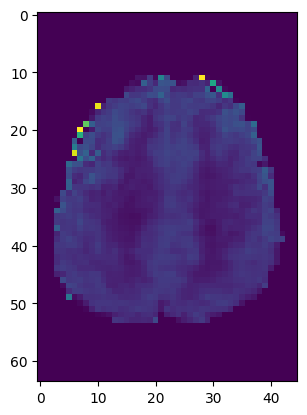

In [35]:
metab = -1

MAP = maps_vanilla[-1,:,10:55]

plt.imshow(MAP)

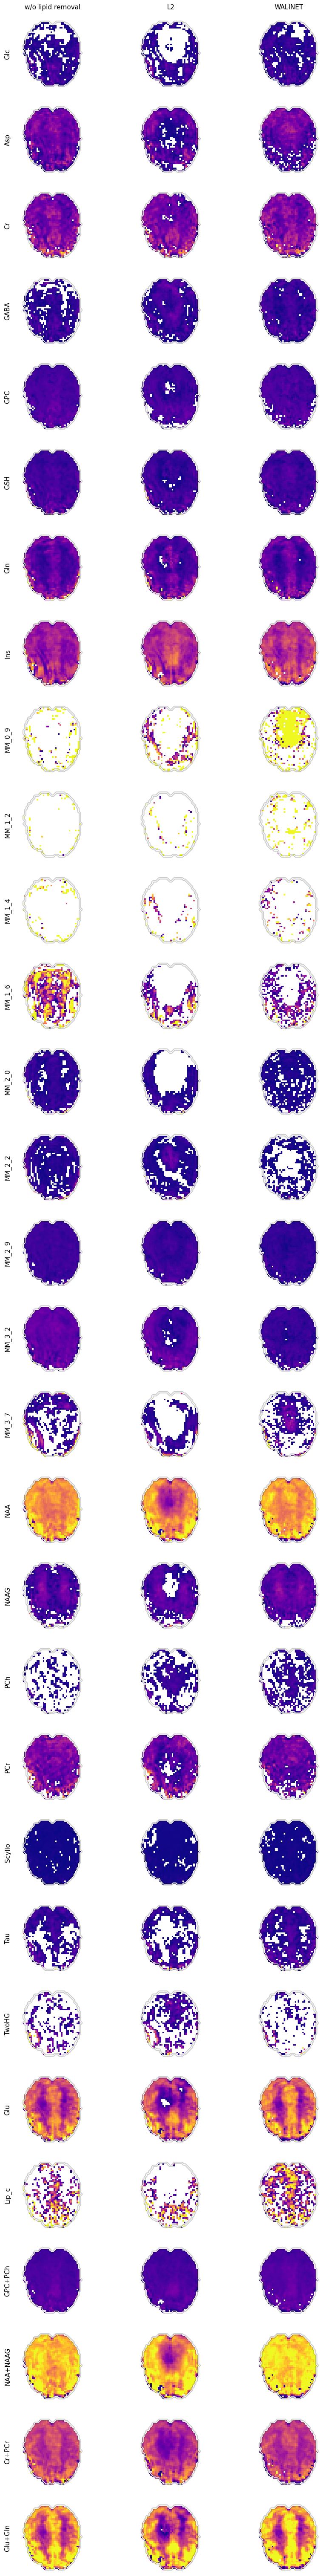

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# 1) mask NaN/Inf in your 4-D arrays
MetabMaps               = np.ma.masked_invalid(MetabMaps)
MetabMaps_L2            = np.ma.masked_invalid(MetabMaps_L2)
MetabMaps_walinet_Water = np.ma.masked_invalid(MetabMaps_walinet_Water)

# 2) extract channel 17 → shape (n_samples, y, x)
maps_vanilla = MetabMaps[:, 17]
maps_L2      = MetabMaps_L2[:, 17]
maps_walinet = MetabMaps_walinet_Water[:, 17]   # “walinet+water”

# 3) compute vmin/vmax on valid pixels
combined = np.concatenate([
    maps_vanilla.compressed(),
    maps_L2     .compressed(),
    maps_walinet.compressed()
])
vmin, vmax = np.nanpercentile(combined, [1, 99])

# 4) setup colormap (transparent outside brain)
cmap = plt.cm.plasma.copy()
cmap.set_bad(alpha=0.0)

# 5) build your brain mask for z=17, then crop it too
z_idx        = 17
mask_full    = mask[z_idx] * mask_old[:, :, z_idx]   # (full_y, full_x)
y0, y1       = 10, 55
x0, x1       = 10, 55
mask_crop    = mask_full[y0:y1, x0:x1]               # (45, 45)

# 6) plotting grid: n rows × 3 columns
col_titles = ['w/o lipid removal', 'L2', 'WALINET']
n = len(titles)

fig, axes = plt.subplots(
    n, 3,
    figsize=(10, 2.5 * n),
    squeeze=False
)

fig.subplots_adjust(
    left=0.12,   # was 0.08
    right=0.94,  # was 0.98
    top=0.90,    # was 0.94
    bottom=0.10, # was 0.06
    wspace=0.05, # was 0.02
    hspace=0.25  # was 0.18
)

for i in range(n):
    for j, arr in enumerate([maps_vanilla[i],
                             maps_L2[i],
                             maps_walinet[i]]):
        # apply full mask, then crop
        arr_full = arr * mask_full
        arr_crop = arr_full[y0:y1, x0:x1]
        arr_crop = np.ma.masked_where(
            (arr_crop == 0) | ~np.isfinite(arr_crop),
            arr_crop
        )

        # plot the cropped image so it fills the axes
        axes[i, j].imshow(
            arr_crop,
            cmap=cmap,
            vmin=vmin, vmax=vmax,
            origin='lower'
        )

        # draw contour on the cropped mask
        axes[i, j].contour(
            mask_crop, [0.5],
            colors=[(0, 0, 0, 0.2)],
            linewidths=4,
            origin='lower'
        )
        axes[i, j].contour(
            mask_crop, [0.5],
            colors='white',
            linewidths=1.1,
            origin='lower'
        )

        # hide ticks & frame
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        for spine in axes[i, j].spines.values():
            spine.set_visible(False)

        # only top row gets column titles
        if i == 0:
            axes[i, j].set_title(col_titles[j],
                                 fontsize=11, pad=18)

        # only first column gets the row label
        if j == 0:
            axes[i, j].set_ylabel(
                titles[i],
                rotation=90,
                fontsize=11,
                labelpad=18,
                va='center'
            )

plt.show()





In [52]:
import numpy as np
import matplotlib.pyplot as plt
import os

# make output folder
os.makedirs("metabolite_images", exist_ok=True)

# 1) mask NaN/Inf
MetabMaps               = np.ma.masked_invalid(MetabMaps)
MetabMaps_L2            = np.ma.masked_invalid(MetabMaps_L2)
MetabMaps_walinet_Water = np.ma.masked_invalid(MetabMaps_walinet_Water)

# 2) extract channel 17
maps_vanilla = MetabMaps[:, 17]
maps_L2      = MetabMaps_L2[:, 17]
maps_walinet = MetabMaps_walinet_Water[:, 17]

# 3) shared colour scale
combined = np.concatenate([
    maps_vanilla.compressed(),
    maps_L2     .compressed(),
    maps_walinet.compressed()
])
vmin, vmax = np.nanpercentile(combined, [1, 99])

# 4) colormap (transparent outside brain)
cmap = plt.cm.plasma.copy()
cmap.set_bad(alpha=0.0)

# 5) define crop window and mask
y0, y1 = 10, 55
x0, x1 = 10, 55
mask_full = mask[17] * mask_old[:, :, 17]
mask_crop = mask_full[y0:y1, x0:x1]

# 6) export each metabolite
for i, name in enumerate(titles):
    fig, axes = plt.subplots(1, 3,
                             figsize=(9, 3),
                             squeeze=False)
    fig.subplots_adjust(left=0.02, right=0.98,
                        top=0.98, bottom=0.02,
                        wspace=0.02, hspace=0)

    for j, arr in enumerate([maps_vanilla[i],
                             maps_L2[i],
                             maps_walinet[i]]):
        img = arr * mask_full
        img = img[y0:y1, x0:x1]
        img = np.ma.masked_where((img == 0) | ~np.isfinite(img), img)

        ax = axes[0, j]
        ax.imshow(img,
                  cmap=cmap,
                  vmin=vmin, vmax=vmax,
                  origin='lower')
        ax.contour(mask_crop, [0.5],
                   colors=[(0, 0, 0, 0.2)], linewidths=4,
                   origin='lower')
        ax.contour(mask_crop, [0.5],
                   colors='white', linewidths=1.1,
                   origin='lower')

        # remove all ticks and frame
        ax.set_xticks([]); ax.set_yticks([])
        for sp in ax.spines.values():
            sp.set_visible(False)

    # save a clean, label-free PNG
    fig.savefig(f"metabolite_images/{name}.png",
                bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close(fig)



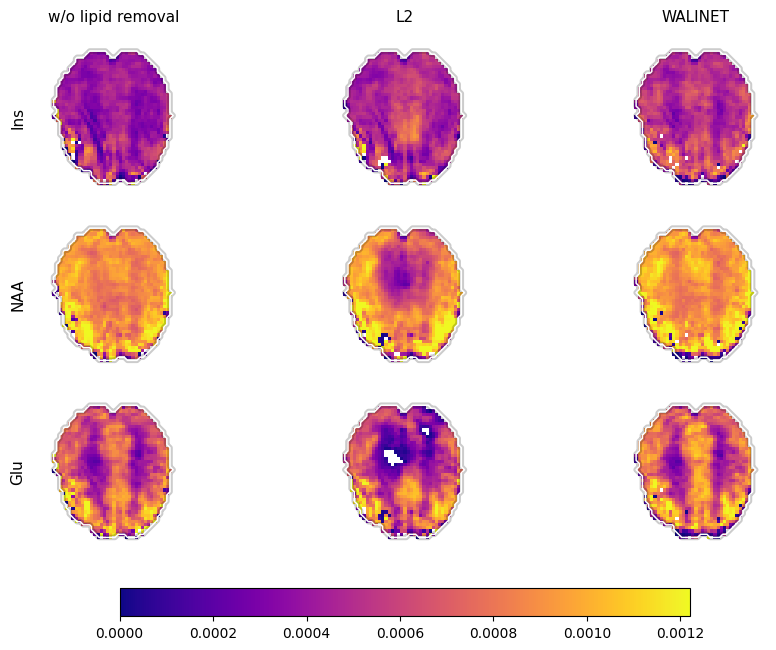

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# 1) mask NaN/Inf
MetabMaps               = np.ma.masked_invalid(MetabMaps)
MetabMaps_L2            = np.ma.masked_invalid(MetabMaps_L2)
MetabMaps_walinet_Water = np.ma.masked_invalid(MetabMaps_walinet_Water)

# 2) extract channel 17
maps_vanilla = MetabMaps[:, 17]
maps_L2      = MetabMaps_L2[:, 17]
maps_walinet = MetabMaps_walinet_Water[:, 17]

# 3) shared colour scale
combined = np.concatenate([
    maps_vanilla.compressed(),
    maps_L2     .compressed(),
    maps_walinet.compressed()
])
vmin, vmax = np.nanpercentile(combined, [1, 99])

# 4) colormap (transparent outside brain)
cmap = plt.cm.plasma.copy()
cmap.set_bad(alpha=0.0)

# 5) build & crop brain mask
z_idx      = 17
mask_full  = mask[z_idx] * mask_old[:, :, z_idx]
y0, y1 = 10, 55
x0, x1 = 10, 55
mask_crop  = mask_full[y0:y1, x0:x1]

# 6) select Ins, NAA, Glu
wanted = ['Ins', 'NAA', 'Glu']
idx = [titles.index(m) for m in wanted]

titles_sel        = [titles[k]       for k in idx]
maps_vanilla_sel  = [maps_vanilla[k] for k in idx]
maps_L2_sel       = [maps_L2[k]      for k in idx]
maps_walinet_sel  = [maps_walinet[k] for k in idx]

# 7) plot grid (3 rows × 3 cols)
col_titles = ['w/o lipid removal', 'L2', 'WALINET']
n = 3

fig, axes = plt.subplots(n, 3,
                         figsize=(10, 2.5 * n),
                         squeeze=False)

# adjust to make room for a horizontal colorbar
fig.subplots_adjust(
    left=0.12, right=0.98,
    top=0.90, bottom=0.14,  # increased bottom margin
    wspace=0.05, hspace=0.25
)

for i in range(n):
    for j, arr in enumerate([
        maps_vanilla_sel[i],
        maps_L2_sel[i],
        maps_walinet_sel[i]
    ]):
        # mask → crop → hide zeros/non-finite
        arr_full = arr * mask_full
        arr_crop = arr_full[y0:y1, x0:x1]
        arr_crop = np.ma.masked_where(
            (arr_crop == 0) | ~np.isfinite(arr_crop),
            arr_crop
        )

        ax = axes[i, j]
        im = ax.imshow(arr_crop,
                       cmap=cmap,
                       vmin=vmin, vmax=vmax,
                       origin='lower')

        # shadow + outline
        ax.contour(mask_crop, [0.5],
                   colors=[(0, 0, 0, 0.2)], linewidths=4,
                   origin='lower')
        ax.contour(mask_crop, [0.5],
                   colors='white', linewidths=1.1,
                   origin='lower')

        # hide ticks & frame
        ax.set_xticks([]); ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)

        if i == 0:
            ax.set_title(col_titles[j], fontsize=11, pad=18)
        if j == 0:
            ax.set_ylabel(
                titles_sel[i],
                rotation=90,
                fontsize=11,
                labelpad=18,
                va='center'
            )

# 8) shared colourbar at bottom
cbar = fig.colorbar(
    im,
    ax=axes[:, :],
    orientation='horizontal',
    fraction=0.05,
    pad=0.08
)
#cbar.set_label('Signal intensity', fontsize=11)

# 9) save
plt.savefig("comparison_Ins_NAA_Glu_cbar_bottom.png",
            dpi=300, bbox_inches='tight')
plt.show()


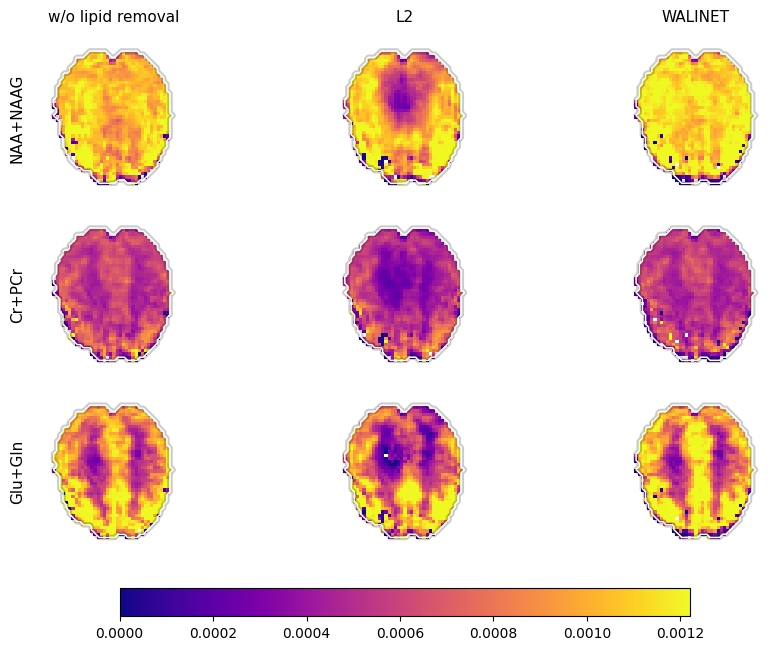

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# 1) mask NaN/Inf
MetabMaps               = np.ma.masked_invalid(MetabMaps)
MetabMaps_L2            = np.ma.masked_invalid(MetabMaps_L2)
MetabMaps_walinet_Water = np.ma.masked_invalid(MetabMaps_walinet_Water)

# 2) extract channel 17
maps_vanilla = MetabMaps[:, 17]
maps_L2      = MetabMaps_L2[:, 17]
maps_walinet = MetabMaps_walinet_Water[:, 17]

# 3) shared colour scale
combined = np.concatenate([
    maps_vanilla.compressed(),
    maps_L2     .compressed(),
    maps_walinet.compressed()
])
vmin, vmax = np.nanpercentile(combined, [1, 99])

# 4) colormap (transparent outside brain)
cmap = plt.cm.plasma.copy()
cmap.set_bad(alpha=0.0)

# 5) build & crop brain mask
z_idx      = 17
mask_full  = mask[z_idx] * mask_old[:, :, z_idx]
y0, y1 = 10, 55
x0, x1 = 10, 55
mask_crop  = mask_full[y0:y1, x0:x1]

# 6) select Ins, NAA, Glu
wanted = ['NAA+NAAG', 'Cr+PCr', 'Glu+Gln']
idx = [titles.index(m) for m in wanted]

titles_sel        = [titles[k]       for k in idx]
maps_vanilla_sel  = [maps_vanilla[k] for k in idx]
maps_L2_sel       = [maps_L2[k]      for k in idx]
maps_walinet_sel  = [maps_walinet[k] for k in idx]

# 7) plot grid (3 rows × 3 cols)
col_titles = ['w/o lipid removal', 'L2', 'WALINET']
n = 3

fig, axes = plt.subplots(n, 3,
                         figsize=(10, 2.5 * n),
                         squeeze=False)

# adjust to make room for a horizontal colorbar
fig.subplots_adjust(
    left=0.12, right=0.98,
    top=0.90, bottom=0.14,  # increased bottom margin
    wspace=0.05, hspace=0.25
)

for i in range(n):
    for j, arr in enumerate([
        maps_vanilla_sel[i],
        maps_L2_sel[i],
        maps_walinet_sel[i]
    ]):
        # mask → crop → hide zeros/non-finite
        arr_full = arr * mask_full
        arr_crop = arr_full[y0:y1, x0:x1]
        arr_crop = np.ma.masked_where(
            (arr_crop == 0) | ~np.isfinite(arr_crop),
            arr_crop
        )

        ax = axes[i, j]
        im = ax.imshow(arr_crop,
                       cmap=cmap,
                       vmin=vmin, vmax=vmax,
                       origin='lower')

        # shadow + outline
        ax.contour(mask_crop, [0.5],
                   colors=[(0, 0, 0, 0.2)], linewidths=4,
                   origin='lower')
        ax.contour(mask_crop, [0.5],
                   colors='white', linewidths=1.1,
                   origin='lower')

        # hide ticks & frame
        ax.set_xticks([]); ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)

        if i == 0:
            ax.set_title(col_titles[j], fontsize=11, pad=18)
        if j == 0:
            ax.set_ylabel(
                titles_sel[i],
                rotation=90,
                fontsize=11,
                labelpad=18,
                va='center'
            )

# 8) shared colourbar at bottom
cbar = fig.colorbar(
    im,
    ax=axes[:, :],
    orientation='horizontal',
    fraction=0.05,
    pad=0.08
)
#cbar.set_label('Signal intensity', fontsize=11)

# 9) save
plt.savefig("comparison_lastthree_cbar_bottom.png",
            dpi=300, bbox_inches='tight')
plt.show()
